In [5]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np

from common.time_layers import *
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

# 5 순환 신경망(RNN)

지금까지의 신경망은 feed-forward 신경망이었다. 흐름이 단방향. 

하지만 이 신경망은 시계열 데이터를 학습하는데 무리가 있다. 그래서 Recurrent Neural Network가 등장한다. 

## 5.1 확률과 언어 모델

### 5.1.1 word2vec을 확률 관점에서 바라보다

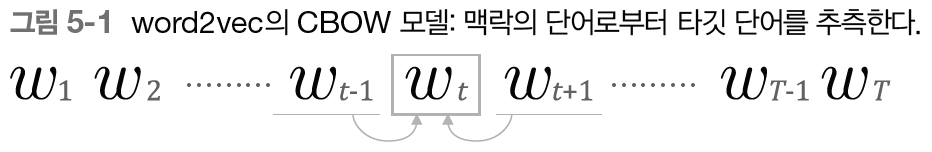

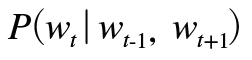

CBOW는 양쪽 window를 좌우대칭으로 놓고 사후 확률을 구했었다. 

하지만 왼쪽 window만 고려한다면, (left = 2, right = 0)

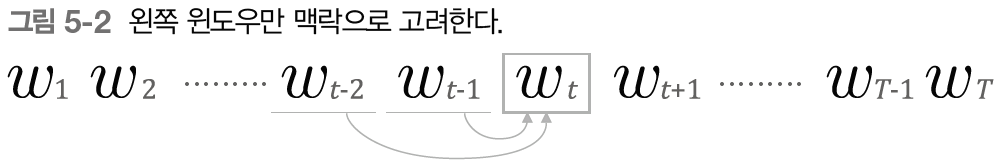

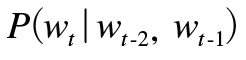 이며, Loss도

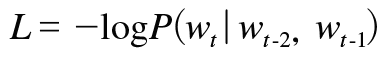 가 된다. 

### 5.1.2 언어 모델 (Language Model)

언어모델은 단어 나열에 확률을 부여한다. 어떤 sequence에 대해서, 그 sequence가 일어날 가능성이 어느 정도인지를 확률로 평가한다. 
- you say goodbye: 높은 확률
- you say good die: 낮은 확률

이는 기계번역과 음성인식에 잘 쓰일 수 있다. 

또한 문장 생성기의 용도로도 사용될 수 있다. 

w1, ..., wm 순서로 출현할 확률을 P(w1, ..., wm)으로 나타내고, 동시확률이라고 부른다. 이를 구해보면, 

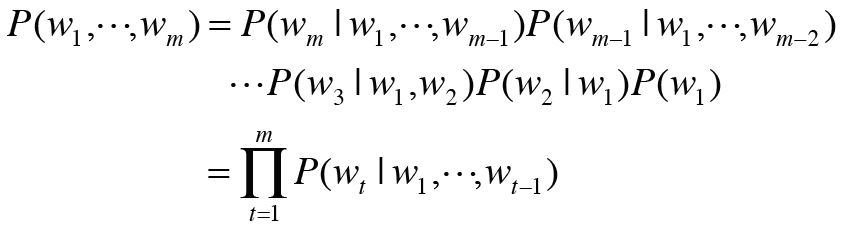
- 처음 w1은 그냥 발생 확률
- 그 다음 w2는 w1이 발생했을 때 발생 확률
- 그 다음 w3는 w1, 2가 발생했을 때 발생 확률
- ...


∏(파이) 기호는 총곱을 나타낸다. 시그마의 * 버전

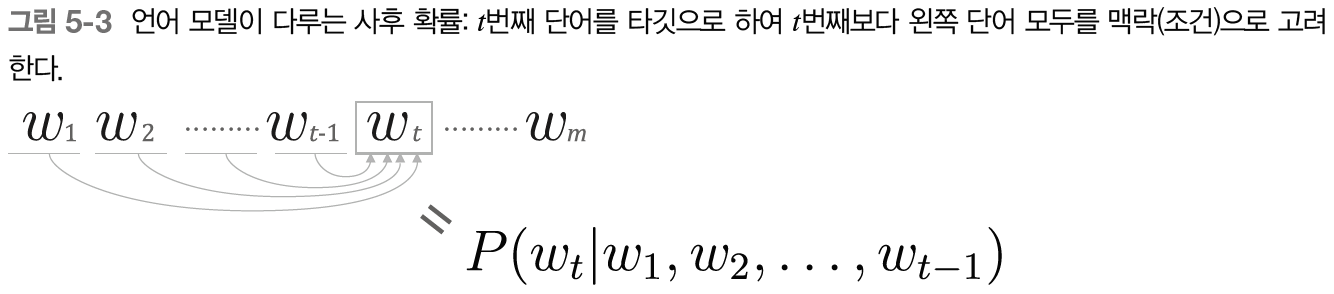

thus, 언어모델(=조건부 언어모델, conditional language model)

### 5.1.3 CBOW 모델을 언어 모델로?

맥락 크기를 특정 값으로 한정하여 근사적으로 CBOW모델을 언어모델에 적용시킬 수 있다. (맥락은 left 2개로 한정) - 실제로 쓰지 않고 설명을 위해 시도한 것이니 참고. 

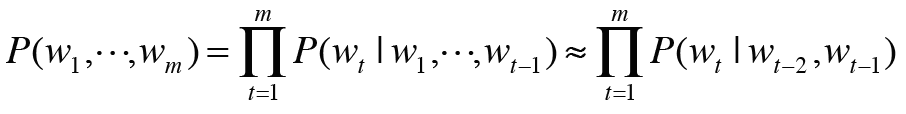

** 참고: Markov Chain/Markov Model
- Markov Chain이란 미래의 상태가 현재 상태에만 의존해 결정되는 것을 말함. 
- 어떤 event(사상)의 확률이 그 직전 N개 사건에만 의존할 때, 이를 Nth Markov Chain이라고 부른다. 
- 위에서 본 것은 2층 마르코프 연쇄라고 볼 수 있다. 

CBOW 모델의 문제점은, 
- 맥락의 길이가 특정 길이로 고정된다. 그 길이보다 더 있어야 정보를 얻어 칸을 채울 수 있을 때 작동하지 않을 수 있다. 
- 맥락 크기를 더 키우더라도, Continuous Bag Of Words 이기 때문에 순서가 없다. 단어 순서가 무시된다. 
- 이를 해결하기 위해 은닉층을 connect하는 방식을 생각해볼 수 있다. 그러나 이 방법도 맥락크기에 비례해 매개변수가 늘어나게 되고, 성능이 떨어지게 된다. 

실제 Neural Probabilistic Language Model에서 제안한 것. 순서 문제를 해결하는 듯 하나 은닉층이 너무 커지게 됨. 

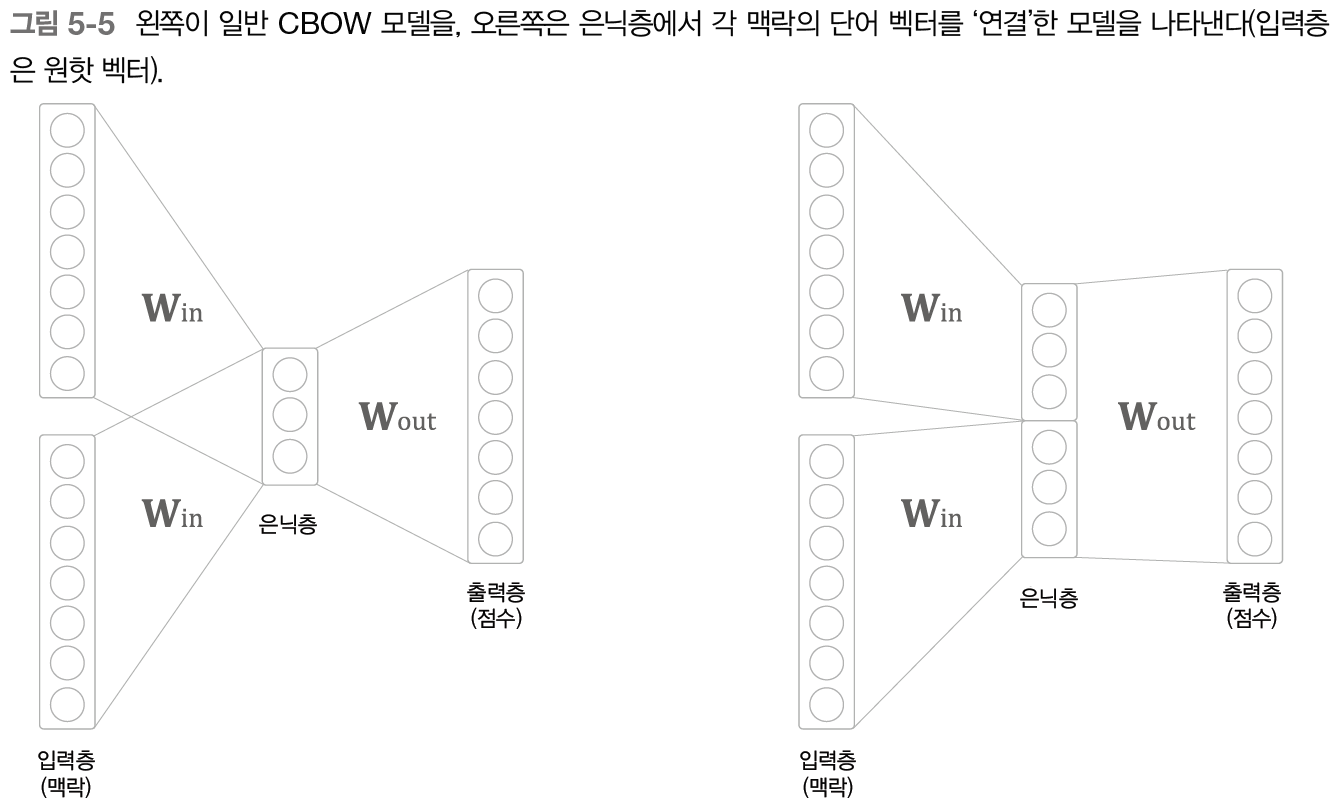

따라서 RNN을 사용해 해결하자. 

## 5.2 RNN이란

Recursive Neural Netowrk (재귀 신경망)은 주로 트리 구조의 데이터 처리를 위한 신경망이다. Recurrent Neural Network와 다르다. 

### 5.2.1 순환하는 신경망

'순환'하기 위해선 닫힌 경로가 필요하다. 순환하는 경로가 필요하며, 이를 통해 과거 정보를 기억하며 동시에 최신 데이터로 갱신된다. 

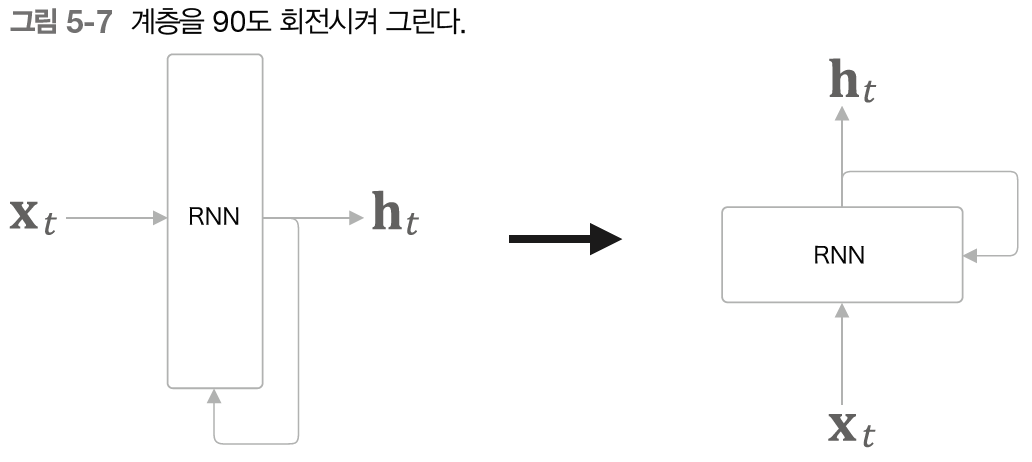

t첨자는 시계열을 의미한다. RNN계층에서 나오는 데이터는 분기되어 하나는 `h_t`로 가고, 나머지 복제는 자기 자신에게 입력된다. 

앞으로 뒤의 설명을 위해 아래에서 위로 가는 모양으로 그리도록 한다. 

### 5.2.2 순환 구조 펼치기

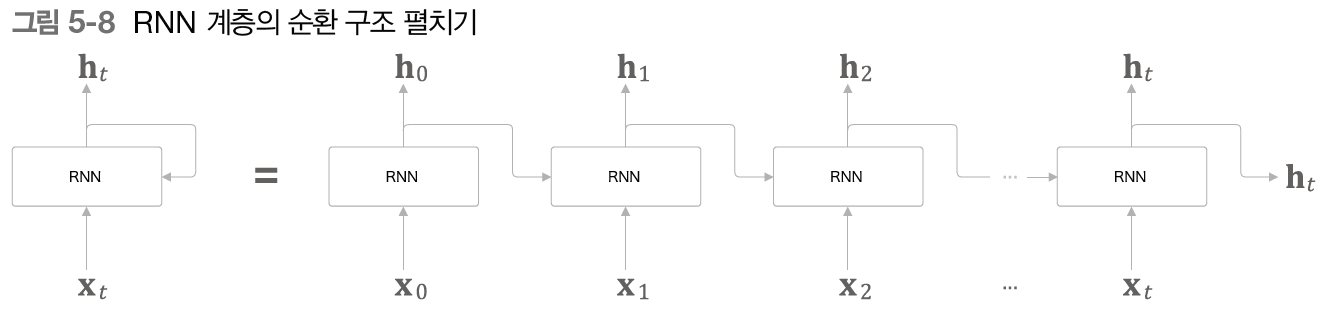

어떻게 보면 feed-forward와 비슷하지만, 매 t의 데이터 입력마다 나오는 다수의 RNN계층은 모두 같은 layer이라는 점에서 다르다. 

이를 식으로 나타내면 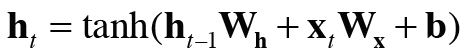 이다.

`x_t`, `h_t-1`를 입력받아 각각 `W_x`, `W_h` 가중치에 넣고 편향 `b`를 더해준다. 가중치가 두 개다. 

tanh는 쌍곡선탄젠트(hyperbolic tangent)이다. 

`h_t`는 직전 출력인 `h_t-1`에 기초되어 계산된다. 즉, `h`는 '상태'를 가지고 있으며 이게 계속 갱신되는 과정이라고 볼 수 있다. 

그래서 RNN계층을 '상태를 가지는 계층' 또는 '메모리(기억력)를 가지는 계층' 이라고 부른다. 

문헌에서 `h_t`를 hidden state 또는 hidden state vector라고 부른다. 

### 5.2.3 BPTT (Backpropagation Through Time)

긴 시계열 데이터를 학습할 때 기울기 소실 문제가 발생한다. 
- t의 증가에 비례해 자원 사용량도 증가. (메모리, 연산 둘 다.)
    - RNN의 중간 데이터를 메모리에 유지해야 BPTT할 수 있기 때문에. 
- 기울기가 불안정해짐. 
    - 1000개의 단어가 있는 말뭉치를 학습시킨다고 할 때, 1000단계를 지나 backpropagation을 할 수는 있지만 너무 멀어지면 끝까지 가기도 전에 기울기가 0이 되어버린다. 

### 5.2.4 Truncated BPTT

큰 시계열을 다룰 때 신경망 연결을 적당한 길이로 '끊는다'. 즉, 적당한 지점에서 잘라내 신경망을 여러 개로 만든다. 이 잘라낸 작은 신경망에서 backpropagation을 수행하는 것이 Truncated BPTT이다. 

이 때, 순전파의 연결은 끊지 않고 역전파에서만 연결을 끊어야 한다. 블록 단위로 나눈다. 

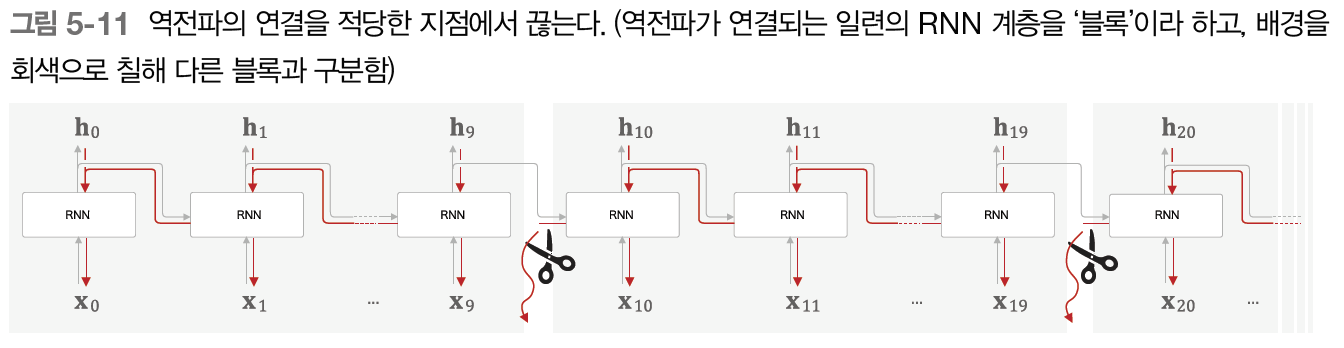

중요한 것은 역전파 연결은 끊어도 순전파 연결은 끊어져선 안된다는 것이다. 

따라서 데이터도 sequential하게 순서를 유지하여 입력해야 한다. 앞의 미니배치 학습처럼 random sampling해서 입력시켜선 안된다. 

첫 번째 블록의 `h9`는 계속 다음으로 이어지는 것을 눈여겨보자. 

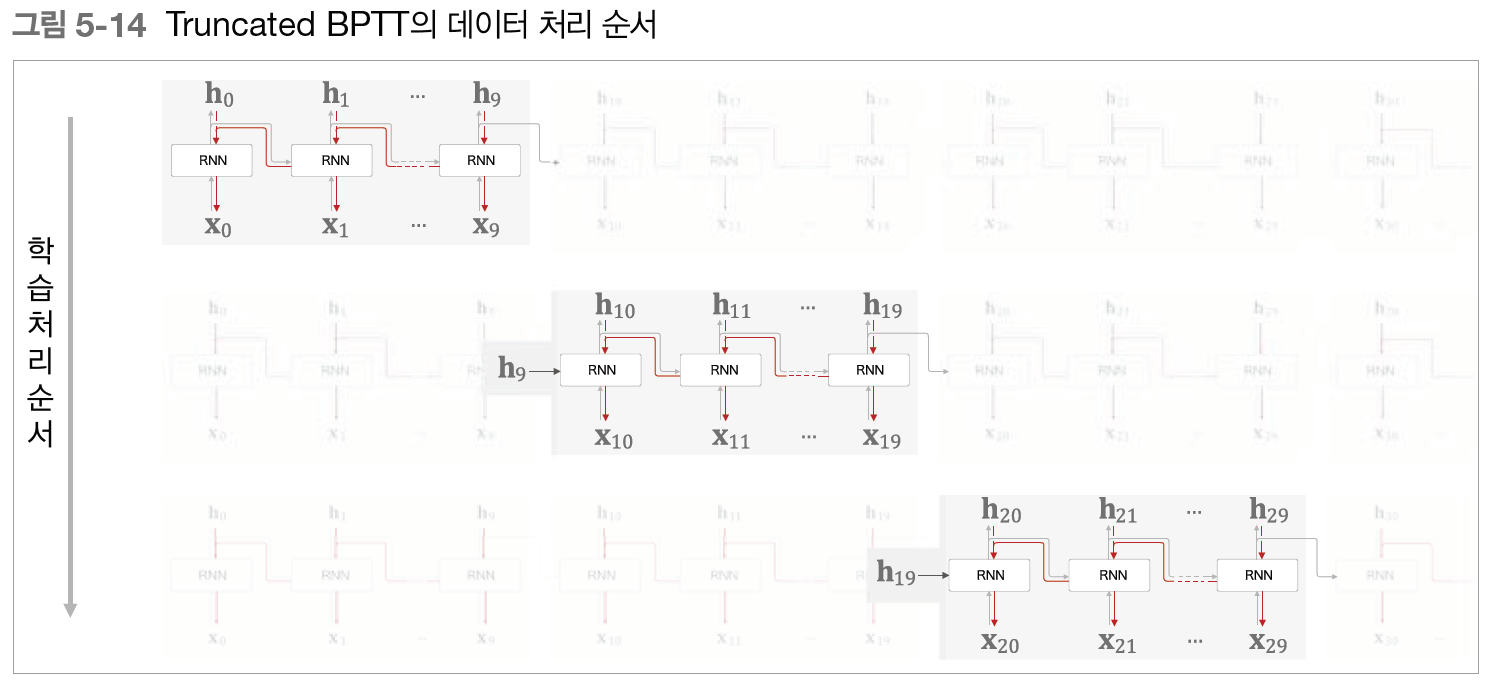

### 5.2.5 Truncated BPTT의 미니배치 학습

지금까지는 미니배치가 1인 경우 (다 집어넣는 경우) 였다. 가령 1000개의 데이터를 2 미니배치로 나눠 학습시킨다면 시작위치를 각 미니배치의 첫 위치로 옮겨줘야 한다. 

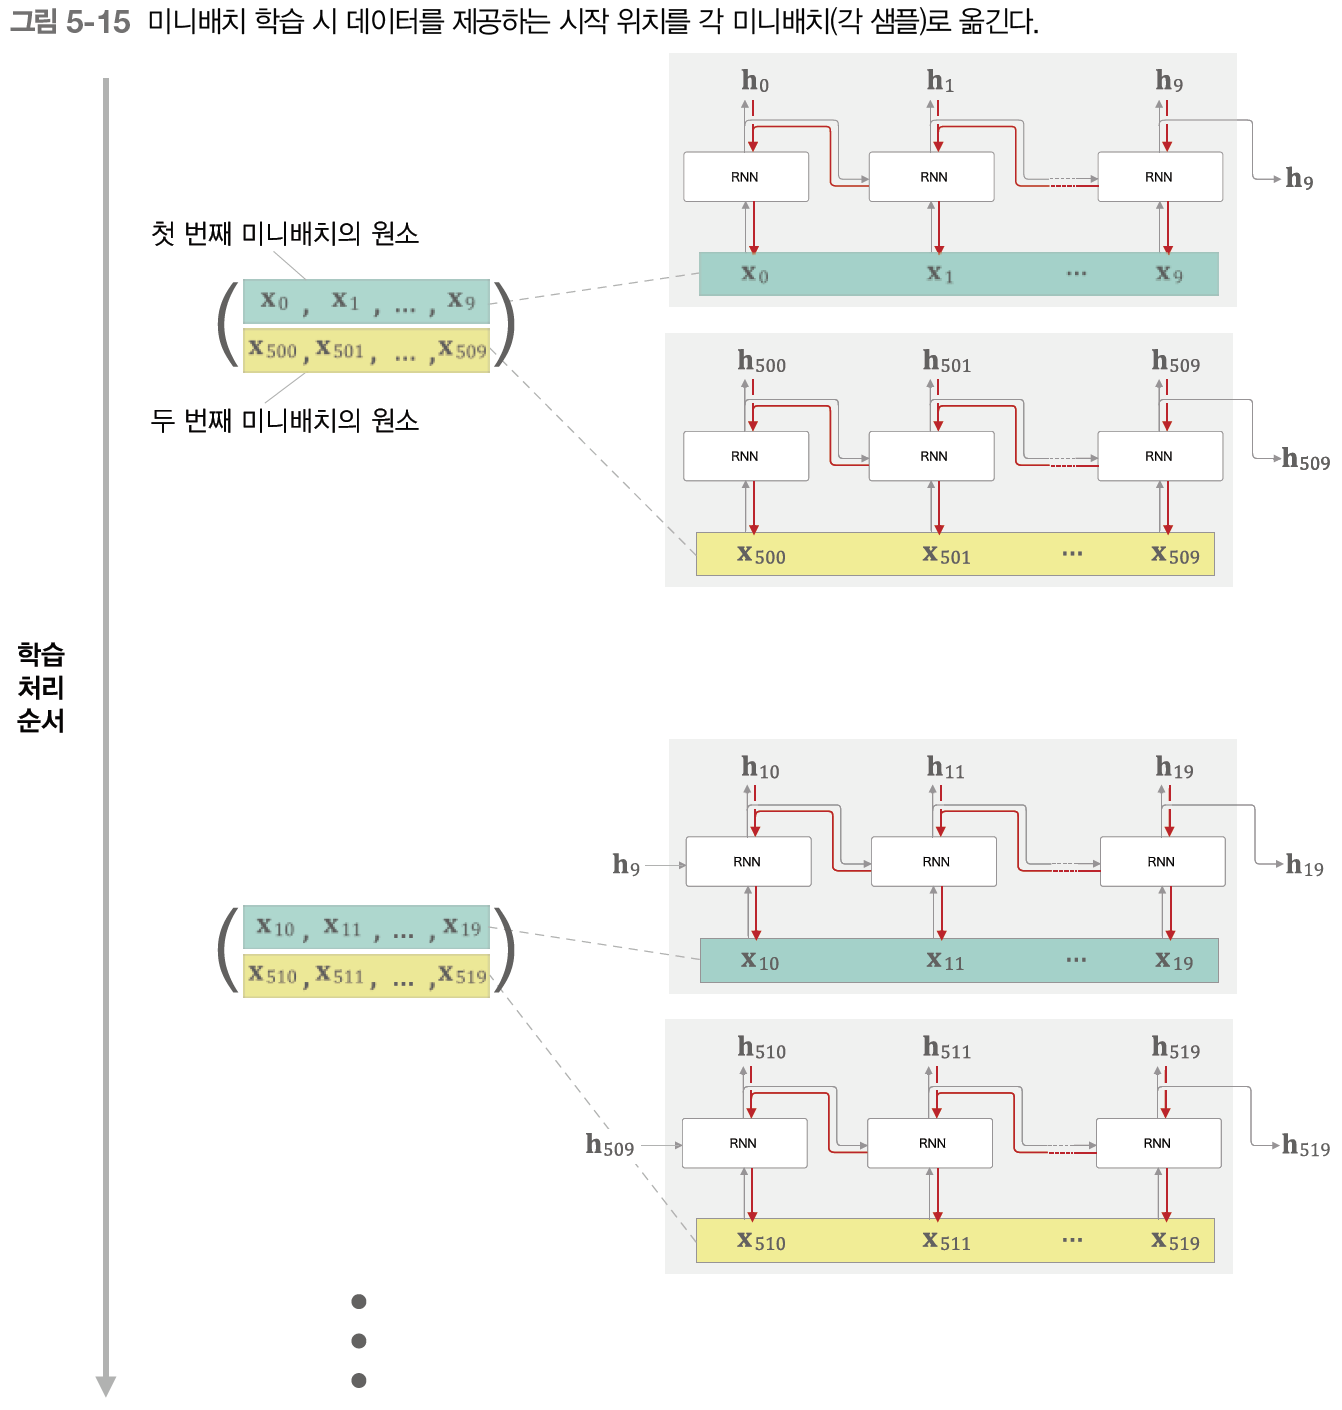

다음을 기억하자. 
- 데이터를 순서대로 제공하기
- 미니배치별로 데이터 시작위치를 옮기기

## 5.3 RNN 구현

T개의 데이터를 다루는 RNN계층을 모두 모아 하나의 Time RNN 계층으로 만든다. 

** 앞으로 앞에 Time ~ 붙으면 데이터를 한꺼번에 처리하는 계층을 뜻함. 이 책에서의 약속임

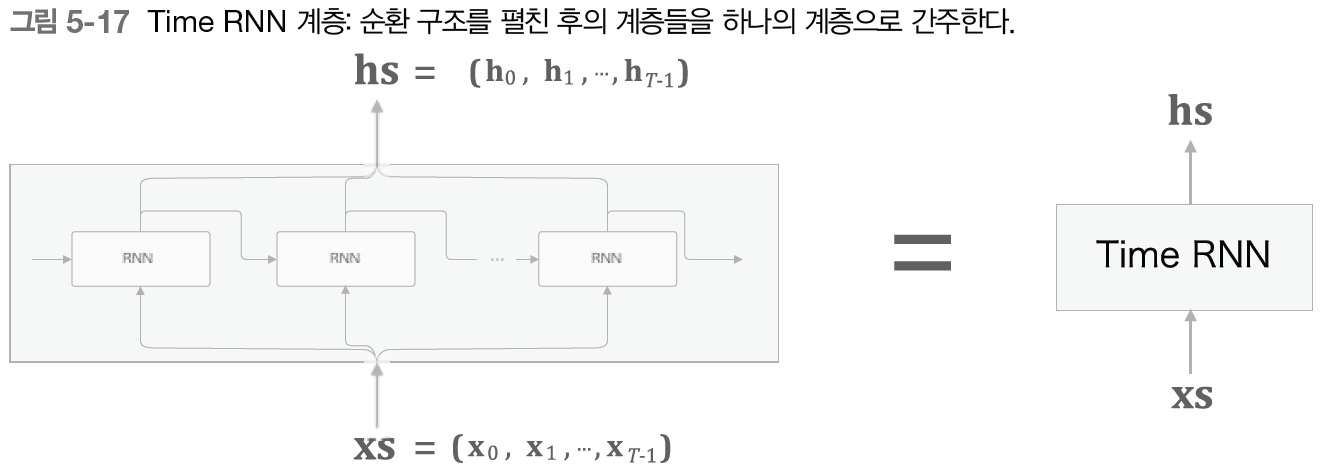

### 5.3.1 RNN 계층 구현

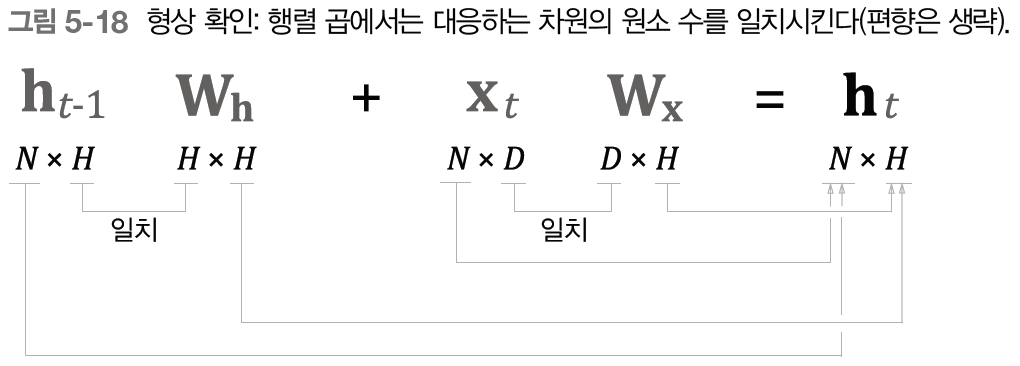

- N: 미니배치 크기
- D: 입력벡터 차원수
- H: 은닉벡터 차원수



In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache(x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

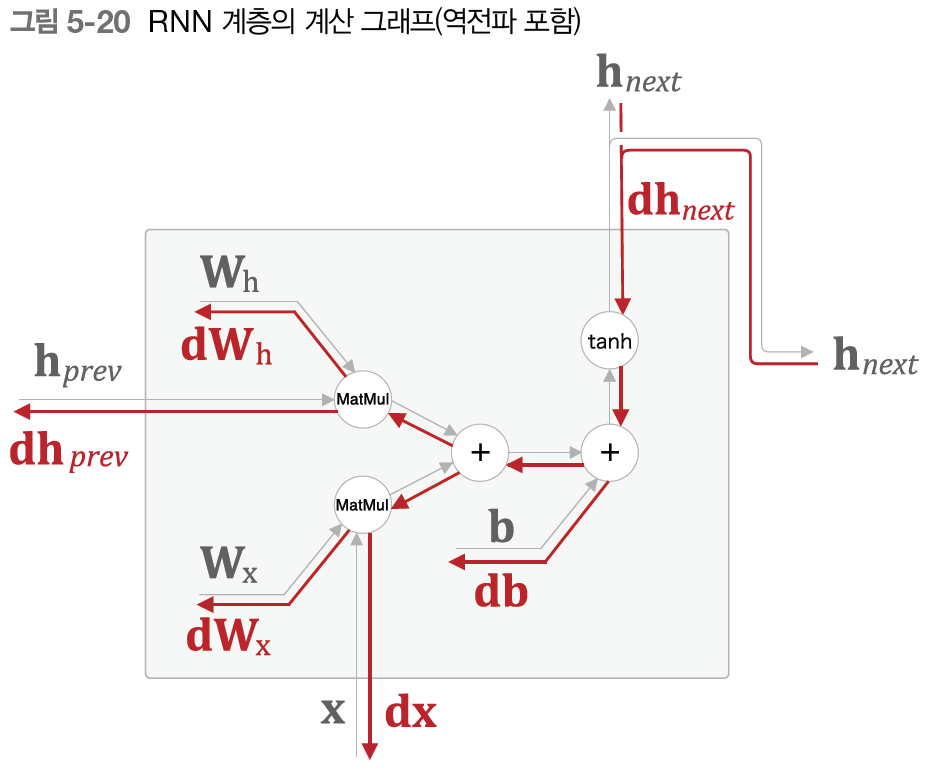

### 5.3.2 Time RNN 계층 구현

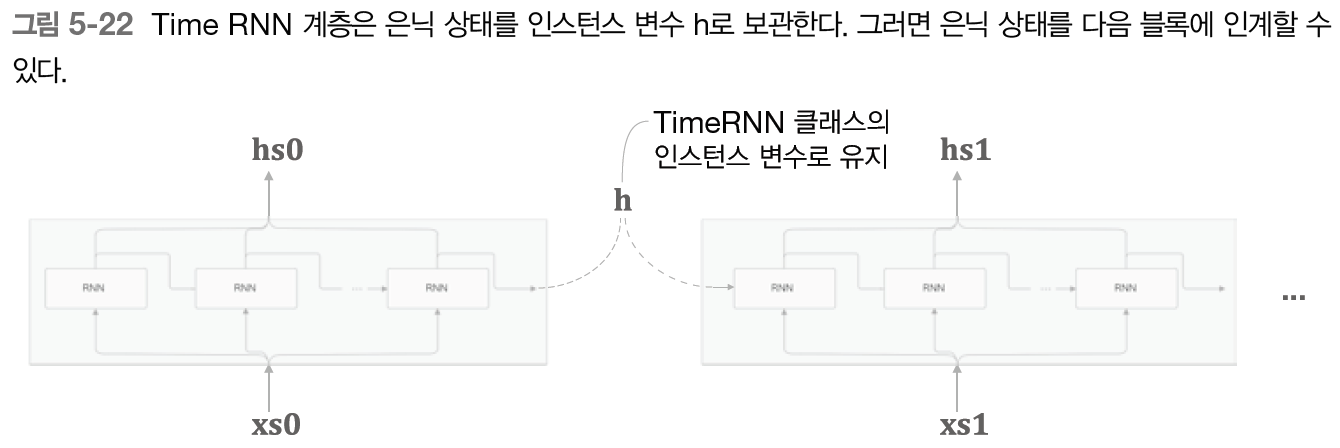

`TimeRNN` 계층에서 인스턴스 변수로 h상태를 유지하면 `RNN` 사이의 인계작업을 계속 생각하지 않아도 된다는 장점이 있음. 

아래에서 `stateful`인자로 은닉상태 유지 여부를 전달받는데, 이는 상용 딥러닝 프레임워크에서도 똑같이 쓰임. 

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False): # stateful: 은닉상태 h를 인계할지. 순전파/역전파에 따라 달라짐. 
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None # 다수의 RNN계층을 리스트로 저장
        
        self.h, self.dh = None, None
        self.stateful = stateful
    
    def set_state(self, h): # for 확장성. 기능임. 
        self.h = h
        
    def reset_state(self): # for 확장성. 기능임. 
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # N: 미니배치 크기, T: 시계열 데이터의 분량, D: 입력 벡터의 차원 수
        D, H = Wx.shape # H: 은닉층 차원 수 
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f') # 출력값을 담을 그릇
        
        if not self.stateful or self.h is None: # 첫 블록이거나 state가 유지되지 않았으면
            self.h = np.zeros((N, H), dtype='f')
        
        for t in range(T): # 데이터 길이만큼. (T)
            layer = RNN(*self.params) # *args처럼. RNN 클래스의 __init__(self, Wx, Wh, b) 에 전달됨. 
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f') # downstream으로 보낼 기울기 담을 그릇 dxs
        dh = 0
        grads = [0, 0, 0]
        for t in reversed([range(T)]): # 뒤에 있는 레이어부터 거꾸로
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) # 합산된 기울기 
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

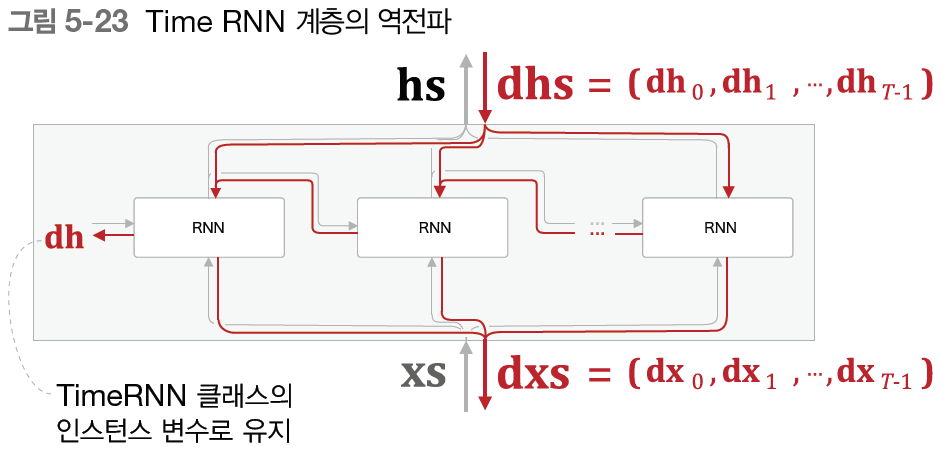

`dh`는 Truncated BPTT에서 유지할 필요가 없지만 이후 seq2seq을 위해 만들어놓는다. 

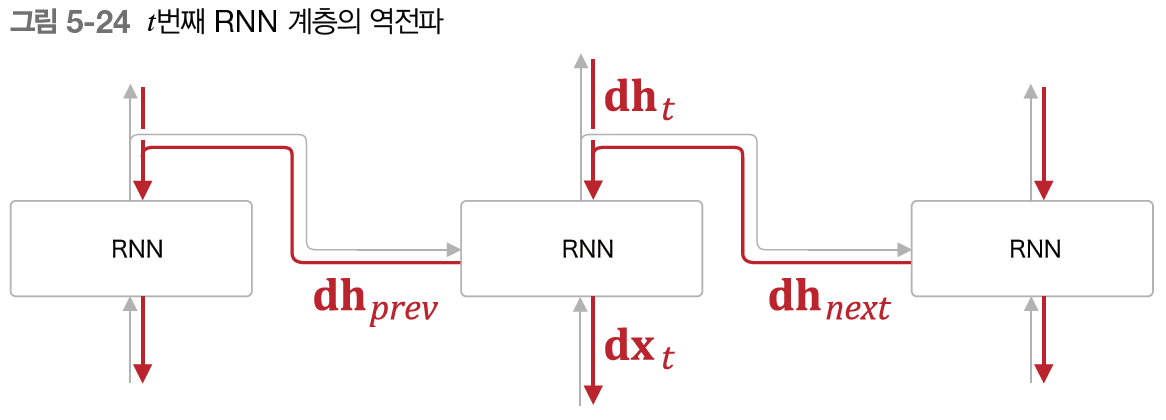

역전파시 합산된 기울기 `dhs[:, t, :] + dh`가 전해진다. 

## 5.4 시계열 데이터 처리 계층 구현

### 5.4.1 RNNLM의 전체 그림

RNNLM (RNN Language Model)을 만들어보겠다. 

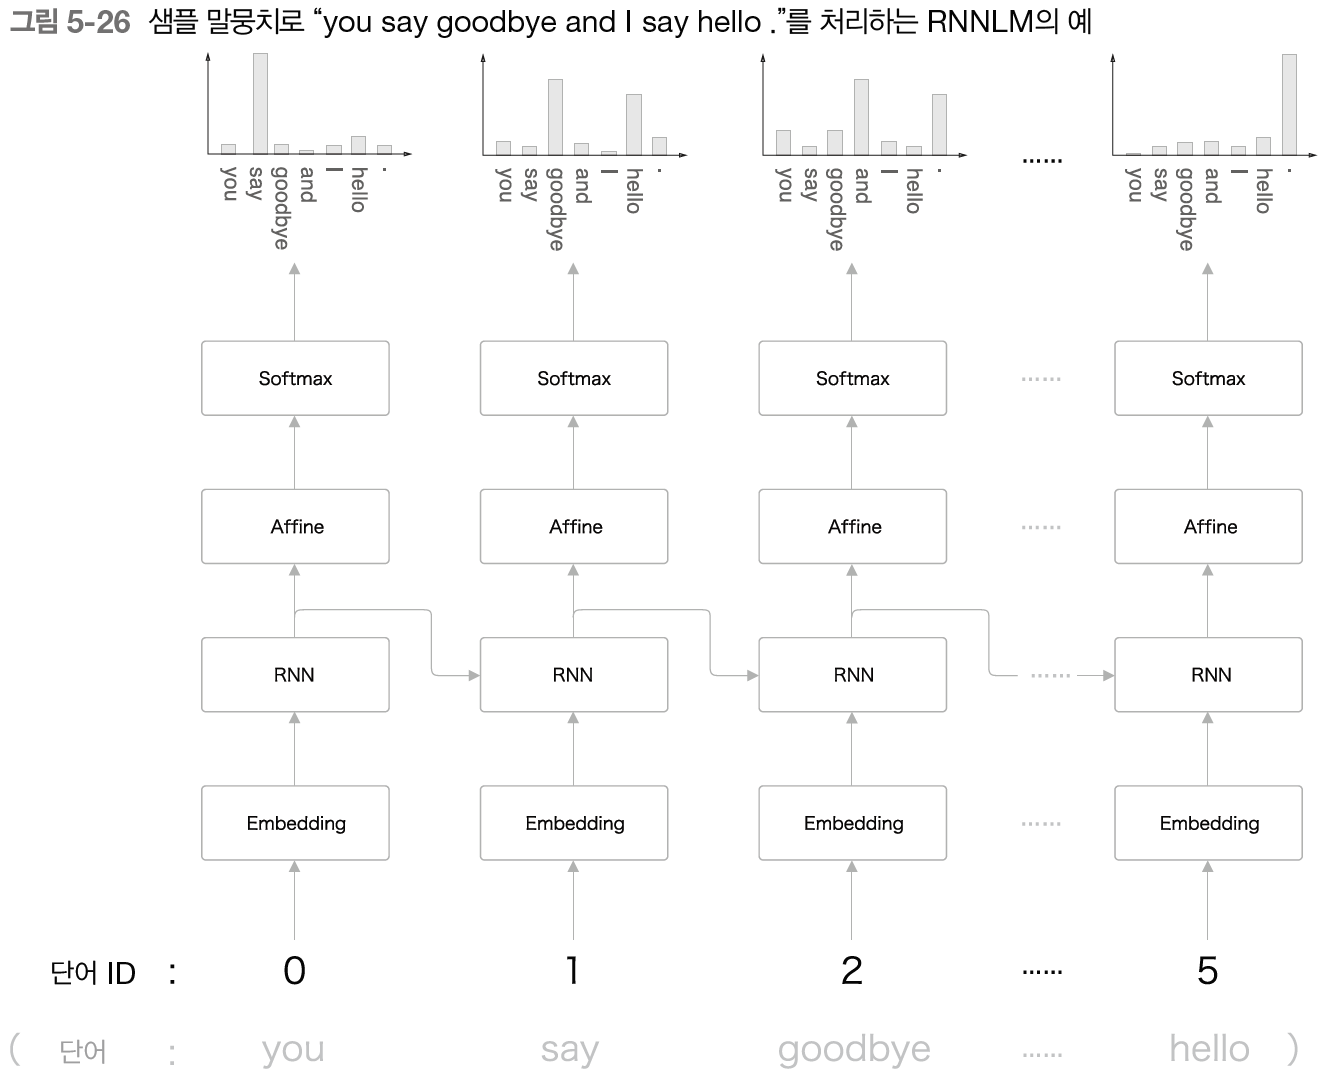

아래에서부터, 
- 먼저 첫 번째 단어id를 embedding 계층에 넣어 분산표현으로 변환하면 `x0`이 된다.
    - 이걸 RNN계층 넣으면 `h0`가 만들어지고, 
        - 하나는 결과를 내기 위해 Affine 계층으로 보내 `y0`를 만들고, 
        - 하나는 복제하여 다음 RNN레이어에 보낸다. (i.e, 같은 RNN레이어에 다시 넣는다.) 
- 다음 단어를 embedding 계층에 넣어 `x1`으로 만든다. 
    - 이걸 RNN계층에 넣으면 `h1 = h0 * Wh + x1 * Wx + b` 가 되어 `h1`이 만들어진다. 
        - 하나는 결과를 내기 위해 Affine 계층으로 보내 `y1`을 만들고, 
        - 하나는 복제하여 다음 RNN레이어에 보낸다. 
        
`y0`은 `x0`다음에 올 것으로 예측되는 단어이고, `y1`은 `x1`다음에 올 것으로 예측되는 단어이다. 

- you --> say
- you say --> goodbye or hello

와 같이 맥락을 기억한 채로 나올만한 것을 확률적으로 출력해준다. goodbye나 hello 무엇이 와도 자연스럽기 때문에 결과에 goodbye, hello 모두 확률이 높게 나오는 것이 잘못된 것이 아니다. 



### 5.4.2 Time 계층 구현

T개의 데이터를 한 번에 다룰 수 있도록 Time xx 계층들을 만들도록 하겠다. 

구체적 구현은 생략. 원리는 아래와 같다. 그냥 T개의 xx계층을 묶어주기만 하면 된다. 

Time Embedding 계층, Time Affine 계층, Time Softmax with Loss 계층을 만든다. 

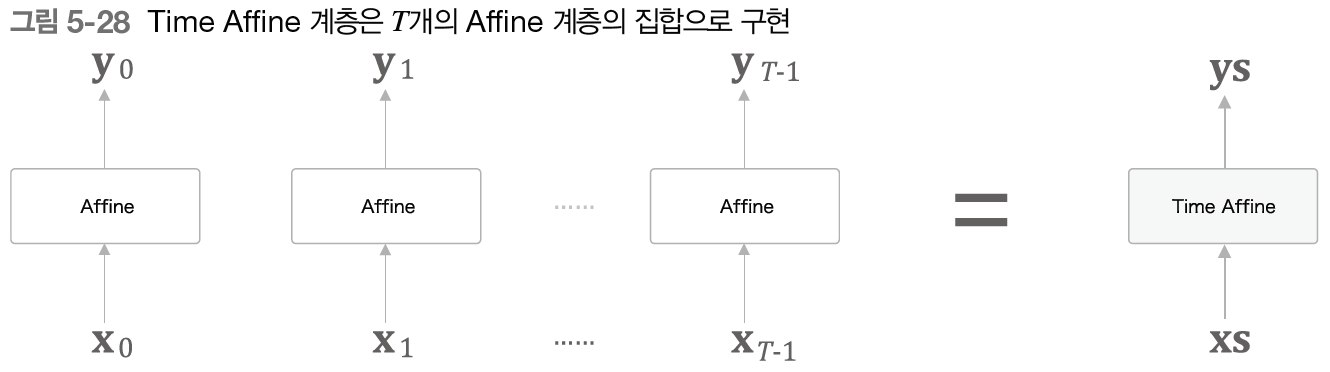

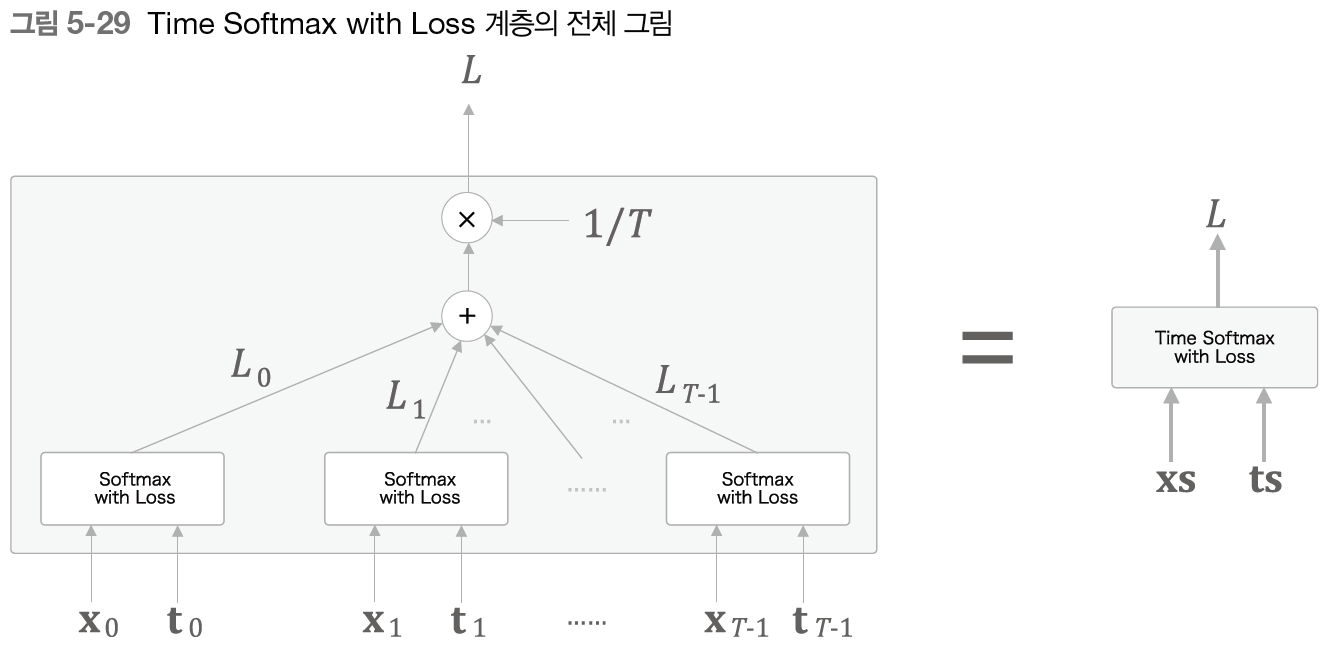

그림에도 나와있듯, L은 L0, L1, ... , L_t-1 (T개) 의 산술평균이다. 

## 5.5 RNNLM 학습과 평가

### 5.5.1 RNNLM 구현

SimpleRnnlm class를 만들겠다. 

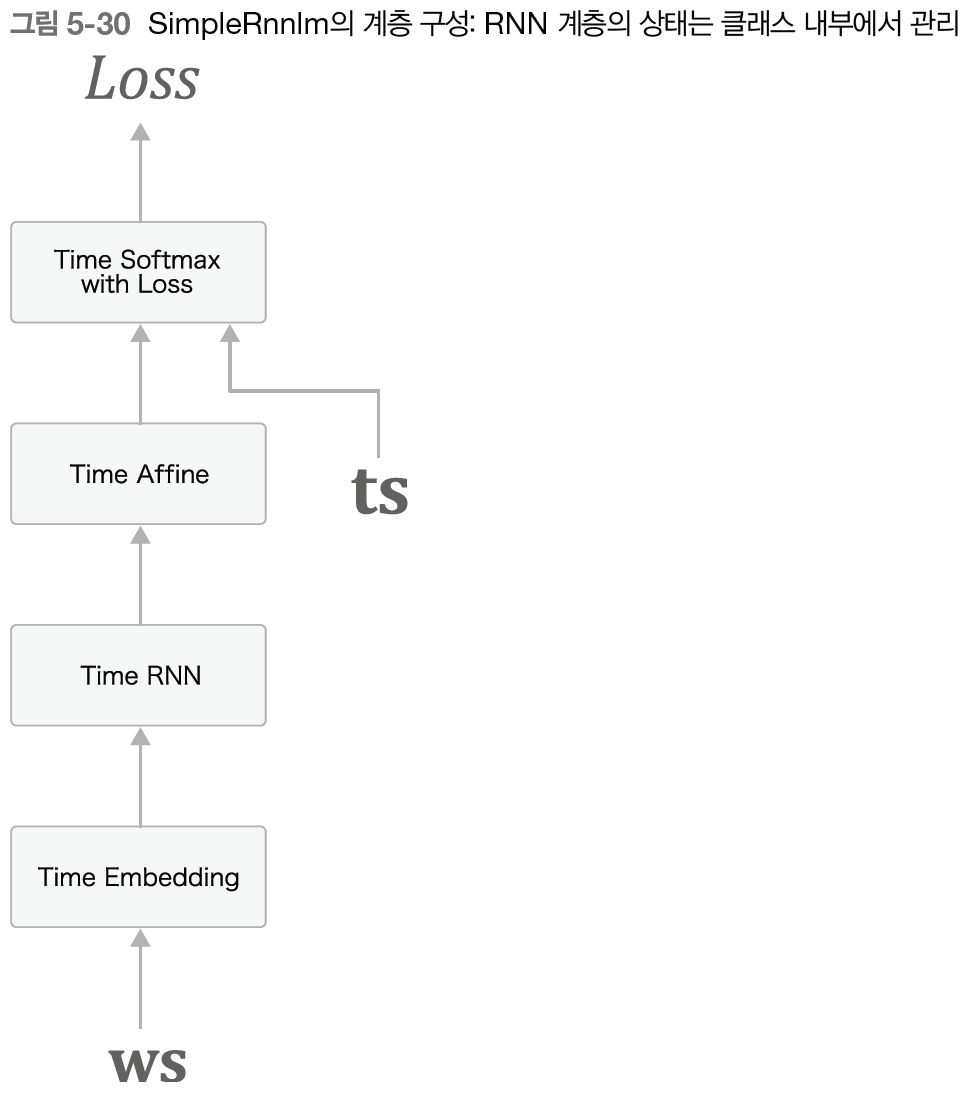

In [4]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다. 
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads == layer.grads
    
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers): # layer 역순으로 backpropagation
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

`TimeRNN`은 당연히 `stateful=True`로 설정한다. 

위 코드에서 `np.sqrt()`로 나눠준 것들은 Xavier 초기값을 써준 것이다. 언어 모델 연구에서는 `0.01 * np.random.uniform(...)` 와같은 균일분포를 이용하는 사례도 많다. 

### 5.5.2 언어 모델의 평가

언어 모델은 과거의 단어로부터 다음에 출현할 단어의 확률분포를 출력한다. 이 예측 성능을 평가하는 척도로 perplexity(혼란도)를 자주 이용한다. 

이는 다음에 올 정답 단어를 예측한 확률의 역수를 취한 값이며, 직관적으로 '분기수'(number of branches)로 해석할 수 있다. 따라서 선택 가능한 분기(후보)의 수가 적을수록, perplexity가 낮을수록 좋은 것이다. 

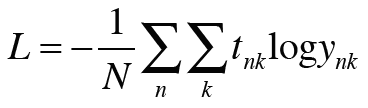 일때 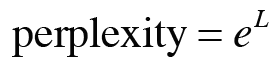
- N: 데이터의 갯수 
- t_n: n번째 원핫 정답 레이블 
- t_nk: n번째 데이터의 k번째 값
- y_nk: 확률분포 (신경망에서는 softmax의 출력) 

이 L은 맨 앞에서 본 교차엔트로피 식이랑 완전히 동일하다. 

정보이론 분야에선 perplexity를 '기하평균 분기 수'라고도 한다. 

### 5.5.3 RNNLM의 학습코드

현재의 모델로는 큰 말뭉치에 대응할 수 없다. 따라서 PTB에서 1000개만 잘라서 쓴다. 

In [8]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN 은닉 상태 벡터 h의 원소 수. 
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기 
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기 (PTB 전체 데이터 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 입력
ts = corpus[1:] # 출력(정답레이블)
data_size = len(xs)
print(f'말뭉치 크기: {corpus_size}, 어휘 수: {vocab_size}')

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = [] # perplexity

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

### 1. 각 미니배치에서 샘플읽기 시작 위치를 계산
jump = (corpus_size -1) // batch_size # (1000 - 1) // 10 == 99
offsets = [ i * jump for i in range(batch_size)] # 0, 99, 198, 297, ...
###

for epoch in range(max_epoch):
    for iter in range(max_iters):
        ### 2. 미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i') # 그릇 준비
        batch_t = np.empty((batch_size, time_size), dtype='i') # 그릇 준비
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        ###
        
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ### 3. epoch마다 perplexity 평가
    ppl = np.exp(total_loss / loss_count)
    print(f'| epoch {epoch+1} | perplexity {ppl}')
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    ###

말뭉치 크기: 1000, 어휘 수: 418
| epoch 1 | perplexity 359.9307689972423
| epoch 2 | perplexity 242.48783352449942
| epoch 3 | perplexity 218.34982363050048
| epoch 4 | perplexity 212.77201757040478
| epoch 5 | perplexity 204.53022533328402
| epoch 6 | perplexity 202.43543862010438
| epoch 7 | perplexity 198.0702810563799
| epoch 8 | perplexity 196.22117942862403
| epoch 9 | perplexity 190.4860970966023
| epoch 10 | perplexity 191.5731944552976
| epoch 11 | perplexity 187.08247345050162
| epoch 12 | perplexity 190.44811331957942
| epoch 13 | perplexity 188.39958206213973
| epoch 14 | perplexity 188.628133043406
| epoch 15 | perplexity 187.23909409878559
| epoch 16 | perplexity 183.10506607144333
| epoch 17 | perplexity 181.07001495508214
| epoch 18 | perplexity 177.6181814495374
| epoch 19 | perplexity 177.55355545085666
| epoch 20 | perplexity 178.89539397780712
| epoch 21 | perplexity 179.98226035120575
| epoch 22 | perplexity 174.33432434157817
| epoch 23 | perplexity 172.14088307842866
| e

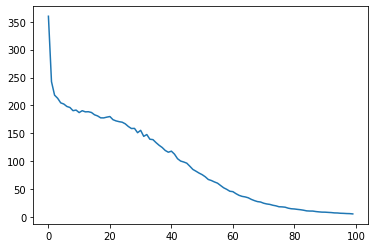

In [10]:
plt.plot(ppl_list)

### 5.5.4 RNNLM의 Trainer 클래스

위의 과정을 `RnnlmTrainer` 클래스로 추상화하여 만들 수 있다. 아마 상용 프레임워크도 다 이런 식으로 되어있을 것이다.

따라서 과정을 기억하는 것이 중요하다. 
1. 미니배치를 순차적으로 만들어 (time series니까)
2. 모델의 순전파와 역전파를 호출하고
3. optimizer로 가중치를 update하고
4. perplexity를 구한다. (loss)|

## 5.6 정리

하지만 RNN은 실제 문제를 잘 학습하지 못했다. 따라서 다음 장에서 LSTM과 GRU를 알아본다. 

- RNN은 순환하는 경로가 있고, 이를 통해 내부에 '은닉 상태'를 기억할 수 있다. 
- RNN의 순환 경로를 펼침으로써 다수의 RNN 계층이 연결된 신경망으로 해석할 수 있으며, 보통의 오차 역전파법으로 학습할 수 있다. (=BPTT)
- 긴 시계열 데이터를 학습할 때는 데이터를 적당한 길이씩 모으고(이를 '블록'이라고 한다), 블록 단위로 BPTT에 의한 학습을 수행한다. (=Truncated BPTT)
- Truncated BPTT에서는 역전파의 연결만 끊는다. 
- Truncated BPTT에서는 순전파의 연결을 유지하기 위해 데이터를 '순차적으로' 입력해야 한다. 
- 언어 모델은 단어 시퀸스를 확률로 해석한다. 
- RNN 계층을 이용한 조건부 언어 모델은 (이론적으로는) 그 때까지 등장한 모든 단어의 정보를 기억할 수 있다. 